## Exponential approach

It consists of applying $2^{n+1}$ times the *State preparation* gate (Creating $2^{n+1}$ copies of $|\psi\rangle$, where $n$ is the number of iterations), completing the iterations and using deferred measurement at the end. For 3 iterations it would look like

<center><img src='img/exp.png' width=500pt/></center>

### Building the function

To build the function that makes $n$ iterations we must follow these steps

<center><img src='img/exp_iter.png' width=500pt/></center>

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit, QuantumRegister, ClassicalRegister, execute

To consider a "random" value, let's say $\zeta = 0.6 e^{i \pi/3}$ Then, 

$$| \psi_1 \rangle = \frac{ 0.82 + 0.31i }{2.127} (|00\rangle + |11\rangle) + \frac{ 1.18 - 0.31i}{2.127} (|01\rangle + |10\rangle) $$

The probabilities are then, 

$P(|00\rangle) = P(|11\rangle) = 0.17 $

$P(|01\rangle) = P(|10\rangle) = 0.33 $



In [36]:
# Function that returns the circuit for n iterations and the output for an initial state c
# It also receives two general unitaries, which will be a CNOT and Hadamard gate in this case

def circuit(n_iter,unitary2,unitary1,c,backend=Aer.get_backend("qasm_simulator"),shots=8192):
    
    NQ = 2**(n_iter+1) # Number of qubits
    qr = QuantumRegister(NQ,"qubit") # Quantum register
    cr = ClassicalRegister(NQ,"bits") # Classical register, every qubit is measured 
    QC = QuantumCircuit(qr,cr) # Base Quantum Circuit - All iterations will be appended to this circuit
    
    for i in range(NQ): 
        if (i%2==0): # Initialize pairs of states in c
            QC.initialize(c,[i,i+1])    
    
    tqc = QuantumCircuit(2) # Temporary quantum circuit 
    for k in range(1,1+n_iter): 
        num = 2**k
        qc = QuantumCircuit(2*num) # 2^{k+1} quantum circuit for buiding k iterations. k goes up to n_iter 
        qc = qc.compose(tqc,range(num)) # Re-building stage
        qc = qc.compose(tqc,range(num,2*num)) # Copying for the next set of qubits stage
        qc.unitary(unitary2,[0,num],label="U2") # Completing the iterations
        qc.unitary(unitary2,[1,num+1],label="U2") # Completing the iterations
        qc.unitary(unitary1,[0],label="U1") # Completing the iterations
        qc.unitary(unitary1,[1],label="U1") # Completing the iterations
        tqc = qc # New temporary circuit for buiilding the next iteration
    
    QC = QC.compose(qc,range(NQ)) # Putting the iterations on the base circuit 
    QC.barrier()
    QC.measure([qr[0],qr[1]],[cr[0],cr[1]]) # Measurements to check the output state (to be more <<not always>> entangled)
    QC.measure([qr[i] for i in range(2,NQ)],[cr[i] for i in range(2,NQ)]) # Measure the remaining qubits to post-select
    
    
    job = execute(QC,backend = backend,shots = shots) 
    output = job.result().get_counts()

    new_output = {} # Post-selected counts are stored here
    val = ''
    aux = ''
    
    for i in range(2**(n_iter+1)-2): # Creating a string of zeros of length NQ-2 to post-select with respect to 
        val = val + '0'

    tot_counts = 0 # Needed later on to normalize the new output
    
    for v in output.items(): # Search in the counts dictionary for 0000...0000(q1q0)
        u = v[0]
        if (u.startswith(val)==True):
            u = u[2**(n_iter+1)-1]+u[2**(n_iter+1)-2] # Keep only q1q0 (last two elements because of the qiskit's convention)
            new_output[u] = v[1] 
            tot_counts = tot_counts + v[1]
    
    for x in new_output.items():
        new_output[x[0]] = x[1]/tot_counts
    
    return [QC,new_output]

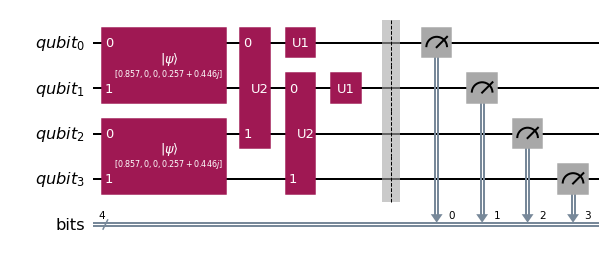

<BarContainer object of 4 artists>

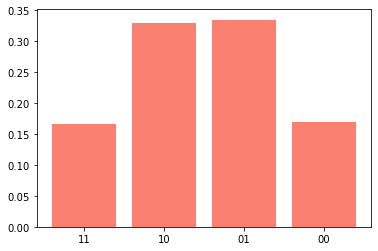

In [46]:
n_iter = 1
z = 0.6*np.exp(np.pi/3)
U2 = [[1,0,0,0],
      [0,0,0,1],
      [0,0,1,0],
      [0,1,0,0]];
U1 = [[1/np.sqrt(2),1/np.sqrt(2)],
      [1/np.sqrt(2),-1/np.sqrt(2)]];
c = [5/np.sqrt(34),
     0,
     0,
     3*np.exp(1j*np.pi/3)/np.sqrt(34)]

qc,counts = circuit(n_iter,unitary2=U2,unitary1=U1,c=c)
display(qc.draw('mpl',style='iqx'))
plt.bar(counts.keys(), counts.values(), color='salmon')

Which is consistent with 

$P(|00\rangle) = P(|11\rangle) = 0.17 $

$P(|01\rangle) = P(|10\rangle) = 0.33 $


### More iterations 

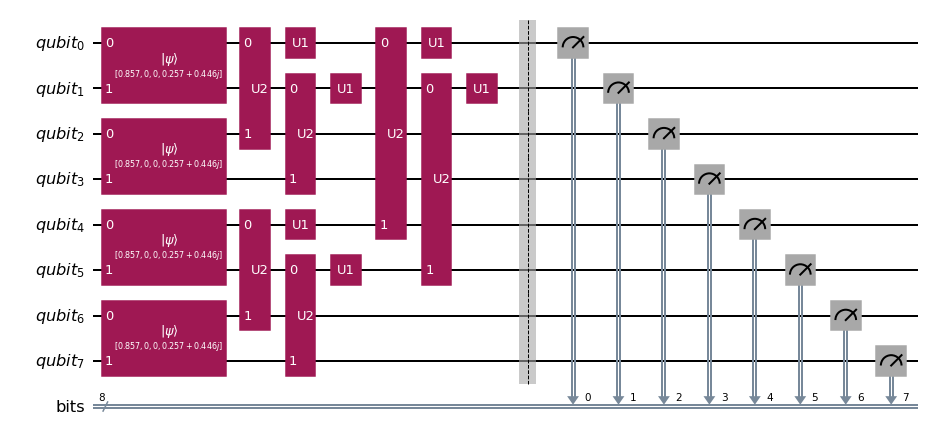

<BarContainer object of 2 artists>

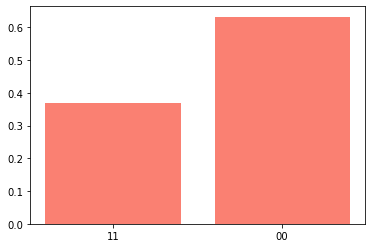

In [47]:
n_iter = 2

qc,counts = circuit(n_iter,unitary2=U2,unitary1=U1,c=c)
display(qc.draw('mpl',style='iqx'))
plt.bar(counts.keys(), counts.values(), color='salmon')